In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

import cv2
import os
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
classes = ["hotdog", "nothotdog"]

In [3]:
import zipfile
with zipfile.ZipFile('./drive/MyDrive/hotdogs/imges.zip', 'r') as zip_ref:
    zip_ref.extractall('tmp')


In [4]:
## loading images
from skimage import io
from skimage import img_as_ubyte

def load_img(indir, class_to_keep):
    samples = []
    labels = []
    #print(os.listdir(indir))
    for class_dir in os.listdir(indir):
        the_class = class_dir
        if the_class in class_to_keep:
            print(class_dir)
            for file in os.listdir(indir+'/'+class_dir):
              image = io.imread("{}/{}/{}".format(indir,class_dir,file))
              image = img_as_ubyte(image)
              image = cv2.resize(image, (256,256))
              samples.append(image)
              labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels


samples, labels = load_img('tmp/imges', classes)
print('loaded',len(samples),' samples')

print('classes',set(labels))

# normalization
samples = samples / 255.0



hotdog
nothotdog
loaded 4832  samples
classes {'nothotdog', 'hotdog'}


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

## Creating a Model

model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(256,256,3)))
print("10%")
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("20%")
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
print("40%")
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.25))
print("60%")
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
print("70%")
model.add(Activation("sigmoid"))
model.add(Dense(2))
model.add(Activation("softmax"))
print("90%")
model.summary()
print("100%")

10%
20%
40%
60%
70%
90%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                

In [6]:
from sklearn.preprocessing import LabelEncoder

#encode labesls to one-hot labels

encoder = LabelEncoder() # encoder
intlabels = encoder.fit_transform(labels)
labels = tf.keras.utils.to_categorical(intlabels)
print("One-hot labels",labels.shape)

One-hot labels (4832, 2)


IndexError: list index out of range

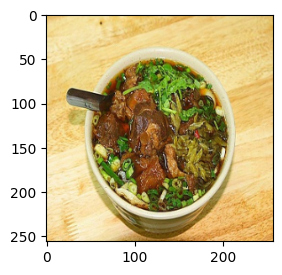

In [7]:
## showing the loaded samples:

import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(classes[n])
    plt.axis("off")

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,train_size=0.80,random_state=42)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#spliting the set and compiling the model

(4832, 256, 256, 3)


In [ ]:
#Training the model

H = model.fit(trainSamples, trainLabels, epochs=30, batch_size=30, validation_data=(testSamples,testLabels))

print("Done")

Epoch 1/5
129/129 [==============================] - 25s 192ms/step - loss: 0.2230 - accuracy: 0.9040 - val_loss: 0.7049 - val_accuracy: 0.7125
Epoch 2/5
129/129 [==============================] - 22s 169ms/step - loss: 0.2132 - accuracy: 0.9128 - val_loss: 0.6617 - val_accuracy: 0.7249
Epoch 3/5
129/129 [==============================] - 24s 183ms/step - loss: 0.1832 - accuracy: 0.9226 - val_loss: 0.6981 - val_accuracy: 0.7218
Epoch 4/5
129/129 [==============================] - 24s 185ms/step - loss: 0.1533 - accuracy: 0.9376 - val_loss: 0.8443 - val_accuracy: 0.7073
Epoch 5/5
129/129 [==============================] - 23s 174ms/step - loss: 0.1458 - accuracy: 0.9402 - val_loss: 0.7324 - val_accuracy: 0.7177
Done


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))

31/31 [==============================] - 2s 67ms/step
[[364 136]
 [137 330]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       500
           1       0.71      0.71      0.71       467

    accuracy                           0.72       967
   macro avg       0.72      0.72      0.72       967
weighted avg       0.72      0.72      0.72       967

CNN Accuracy: 0.72
Cohen's Kappa: 0.43


1/1 [==============================] - 0s 27ms/step
Image classified as class nothotdog with probalility 0.9999991655349731


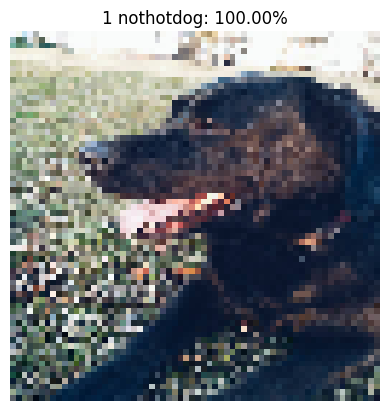

In [ ]:
image = cv2.imread("66.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64,64))

# add one dimension
image2 = np.expand_dims(image, axis=0)

#add tensor
baseImage= tf.constant(image2, dtype=tf.float32)
# predict
real_pred = model.predict(image2)
real_max = real_pred[0].argmax()
#real_label = pred[0][1]
plt.imshow(image)
plt.title(f"{real_max} {classes[real_max]}: {real_pred[0][real_max]*100:.2f}%")
plt.axis("off")
print(f'Image classified as class {classes[real_max]} with probalility {real_pred[0][real_max]}')